In [ ]:
import os 

import pandas as pd
import numpy as np
import scanpy as sc


from SURE import DensityFlow
from SURE.perturb import DoseMatrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA

import torch
torch.set_float32_matmul_precision("high")

import seaborn as sns
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 仅显示GPU 0


In [2]:
adata_ = sc.read_h5ad('scTF_seq_adata.h5ad')
adata_ = adata_.raw.to_adata()
adata = adata_.copy()

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, n_top_genes=10000, subset=True)


In [3]:
def count_pert(row):
    if '-' in row['TF']:
        return 2
    elif row['TF']=='D0':
        return 0
    else:
        return 1

adata.obs['nperts'] = adata.obs.apply(count_pert, axis=1)

In [ ]:
pert_col = 'TF'
control_label = 'D0'

xs = adata.X

lb1 = DoseMatrix()
labels = adata.obs[pert_col].tolist()
label_dose = adata.obs['Dose'].tolist()
us1 = lb1.fit_transform(labels, label_dose, sep_pattern='@')
ln1 = lb1.labels_


lb2 = LabelBinarizer().fit(adata.obs['Phase_corrected'])
us2 = lb2.transform(adata.obs['Phase_corrected'])
ln2 = lb2.classes_

lb3 = LabelBinarizer().fit(adata.obs['batch'])
us3 = lb3.transform(adata.obs['batch'])
ln3 = lb3.classes_

us = np.hstack([us1,us2,us3])
ln = np.hstack([ln1,ln2,ln3])

In [5]:
model = DensityFlow.load_model('dose_densityflow_model.pth')

Model loaded from dose_densityflow_model.pth


🧬 DensityFlow Initialized:
   - Codebook size: 15
   - Latent Dimension: 50
   - Gene Dimension: 55536
   - Hidden Dimensions: [512]
   - Device: cuda:0
   - Parameters: 78,685,409


In [6]:
zs = model.get_basal_embedding(xs, batch_size=128, show_progress=False)

us_comp = np.hstack([us1, np.zeros_like(us2), np.zeros_like(us3)])
zs_comp = model.get_complete_embedding(xs, us_comp, show_progress=False)

In [ ]:
pert_gene = 'Mycn-Myog'
pert_gene = 'Mycn-Pparg'

subset_idx1 = np.where(adata.obs[pert_col].isin(['D0']))[0]
subset_idx2 = np.where(adata.obs[pert_col].isin([pert_gene]))[0]
subset_idx = np.concat([subset_idx1,subset_idx2], axis=0)
subset_xs = xs[subset_idx]
subset_xs1 = xs[subset_idx1]
subset_xs2 = xs[subset_idx2]
subset_us = us[subset_idx]
subset_zs = zs[subset_idx]

In [37]:
pca_model = PCA(n_components=2)
pos = pca_model.fit_transform(zs_comp[subset_idx])
ad = sc.AnnData(pos, obs=adata[subset_idx].obs.copy())
ad.obsm['X_pca'] = pos

In [38]:
ad.obs[pert_col] = ad.obs[pert_col].astype(str)

In [39]:
ad.obs[ad.obs[pert_col]==pert_gene] = f'${pert_gene}$'
ad.obs[pert_col] = pd.Categorical(ad.obs[pert_col], categories=['D0', f'${pert_gene}$'], ordered=True)

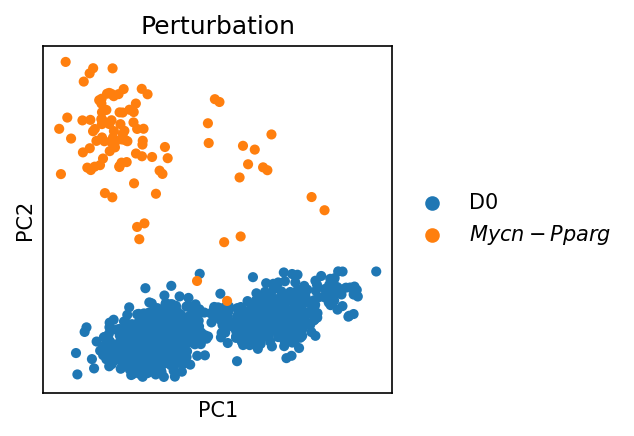

In [40]:
with plt.rc_context({'figure.dpi': 150,'figure.figsize':(3,3)}):
    sc.pl.pca(ad, color=pert_col, title='Perturbation', show=True)

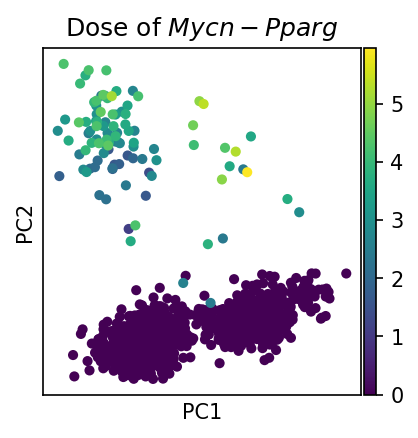

In [11]:
with plt.rc_context({'figure.dpi': 150,'figure.figsize':(3,3)}):
    sc.pl.pca(ad, color='Dose', title=f'Dose of ${pert_gene}$')

In [12]:
color_map = dict(zip(ad.obs[pert_col].cat.categories, ad.uns[f'{pert_col}_colors']))

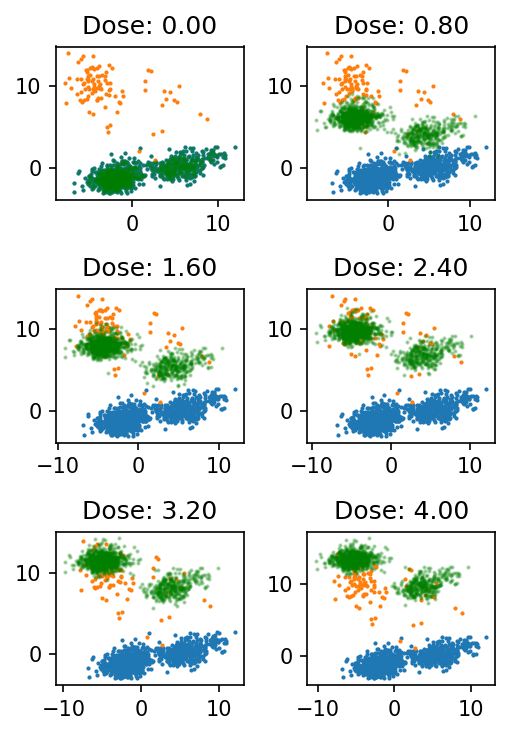

In [ ]:
dose_values = np.linspace(0,4,num=6,endpoint=True)

perts = pert_gene.split('-')

plt.figure(figsize=(3.5,5), dpi=150)

for i,dose in enumerate(dose_values):
    dzs = np.zeros_like(zs[subset_idx1])
    for pert in perts:
        pert_idx = int(np.where(ln==pert)[0])
        pert_cs = us[subset_idx1,pert_idx].reshape(-1,1)
        dzs += model.get_cell_shift(subset_xs1, pert_idx, dose * np.ones_like(pert_cs), show_progress=False)
        
    # control cells
    pos1 = pca_model.transform(zs[subset_idx1])
    # perturbed cells
    pos2 = pca_model.transform(zs_comp[subset_idx2])
    # simulated cells
    pos3 = pca_model.transform(zs[subset_idx1] + dzs)
    
    plt.subplot(3, 2, i + 1)
    plt.scatter(pos1[:,0],pos1[:,1], color=color_map[control_label], s=1)
    plt.scatter(pos2[:,0],pos2[:,1], color=color_map[pert_gene], s=1)
    plt.scatter(pos3[:,0],pos3[:,1], color='green', s=1, alpha=0.3)
    
    plt.title(f'Dose: {dose:.2f}')


plt.tight_layout()
plt.show()